In [1]:
import os
import torch
import ds.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import (
    EarlyStopper,
    TrainingInfo,
    epoch_end_print,
    get_dataloaders,
    get_datasets,
    check_best,
    end_train,
    evaluate,
    train_one_epoch,
)
from torchvision.models import resnet18, ResNet18_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from ds.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import (
    ClassificationEvaluator,
    load_cl_pretrained,
    resnet_set_trainable_layers,
)
from models.classification import MultiBinaryClassificationModel
from torchvision.models.detection import FasterRCNN
import warnings
import pandas as pd
from utils.plot import plot_train
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor
from torchvision import models
from torchmetrics.functional.classification import accuracy
from torch import nn
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from utils.train import get_dataloader_g
import torch.utils.data as data
import math
import numpy as np
from utils.train import collate_fn
import torch.nn.functional as F

from torch import nn
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from utils.train import get_dataloader_g
import torch.utils.data as data
import math
import numpy as np
from utils.train import collate_fn

import torch.nn.functional as F
from tqdm import tqdm
import albumentations
from torchmetrics.detection import MeanAveragePrecision

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device() # torch.device("cpu") # 
# device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128 # 128
batch_size = 4
epochs = 50
linear_eval = True
tune_mode = "linear_eval" if linear_eval else "fine_tuned"
representation_size = 32 # 1024 in paper, but too large on my PC.

In [4]:
model_names = [
    "supervised",
    "simsiam",
    "byol",
    "twins",
    "moco",
    "our_simclr",
    "swav",
    "our_improved_v4",
    "our_improved_v4_without_auto",
    "our_improved_v8",
]  # the models going to run.

replace_strs = {
    "simsiam": "encoder.",
    "byol": "net.",
    "twins": "backbone.net.",
    "moco": "encoder_q.",
    "our_simclr": "img_enc.",
    "swav": "img_enc.",
    "our_improved_v4": "img_enc.",
    "our_improved_v4_without_auto": "img_enc.",
    "our_improved_v8": "img_enc.",
}

In [5]:
def load_pretrained_weights(
    backbone,
    model_name,
):
    if model_name == "supervised":
        return resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    cp = torch.load(
        os.path.join("checkpoints", model_name, "model"), map_location=device
    )
    backbone_cp_dict = {
        k.replace(replace_strs[model_name], ""): v
        for k, v in cp["model"].items()
        if k.startswith(replace_strs[model_name])
    }

    if "fc.weight" in backbone_cp_dict:
        del backbone_cp_dict["fc.weight"]

    if "fc.bias" in backbone_cp_dict:
        del backbone_cp_dict["fc.bias"]

    if len(backbone_cp_dict) == 0:
        raise ValueError(f"No parameters loaded for {model_name}!")

    backbone.load_state_dict(backbone_cp_dict, strict=False)
    return backbone

In [6]:
# run the test to see all the model can be loaded
for model_name in model_names:
    backbone = resnet18(weights=None)
    backbone = load_pretrained_weights(backbone, model_name)

In [7]:
train_d = data.DataLoader(
    REFLACXLesionDetectionDataset(
        image_size=image_size,
        split_str="train",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    generator=get_dataloader_g(0),
    drop_last=False,
)
val_d = data.DataLoader(
    REFLACXLesionDetectionDataset(
        image_size=image_size,
        split_str="val",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    generator=get_dataloader_g(0),
    drop_last=False,
)

test_d = data.DataLoader(
    REFLACXLesionDetectionDataset(
        image_size=image_size,
        split_str="test",
        transform=albumentations.Compose(
            [
                albumentations.Resize(image_size, image_size),
                # no flip.
            ],
            bbox_params=albumentations.BboxParams(
                format="pascal_voc", label_fields=["label"]
            ),
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    generator=get_dataloader_g(0),
    drop_last=False,
)

In [8]:
from utils.tensor import nested_to_device

In [9]:
def train_one_epoch(
    model,
    optimizer,
    dataloader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):
    model.to(device)
    model.train()
    iters = math.ceil(len(dataloader.dataset) / train_d.batch_size)

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    losses = []
    pbar = tqdm(total=len(dataloader))
    for i, (x, y) in enumerate(dataloader):
        x = nested_to_device(x, device)
        y = nested_to_device(y, device)
        loss_dict = model(x, y)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()
        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
        pbar.update()

    pbar.close()
    return losses


cpu_device = torch.device("cpu")


@torch.inference_mode()
def evaluate(model, data_loader, device, get_preds=False):
    model.to(device)
    model.eval()
    evaluator = MeanAveragePrecision(iou_type="bbox", box_format="xyxy")
    losses = []
    if get_preds:
        preds_save = []
    pbar = tqdm(total=len(data_loader))
    for _, (x, y) in enumerate(data_loader):
        x = nested_to_device(x, device)
        y = nested_to_device(y, device)

        with torch.no_grad():
            model.train()
            loss_dict = model(x, y)
            loss = sum(loss for loss in loss_dict.values())
            losses.append(loss.item())
        model.eval()

        y_pred = model(x)
        y_pred = [{k: v.to(cpu_device) for k, v in t.items()} for t in y_pred]

        if get_preds:
            for pred, tgt in zip(y_pred, y):
                for bb, label, score in zip(
                    pred["boxes"], pred["labels"], pred["scores"]
                ):
                    row_save = {}
                    # xyxy
                    row_save.update(
                        {
                            "x1": bb[0].item(),
                            "y1": bb[1].item(),
                            "x2": bb[2].item(),
                            "y2": bb[3].item(),
                            "label": label.item(),
                            "score": score.item(),
                            "image_path": tgt["image_path"],
                            "gt_boxes": tgt["boxes"].cpu().numpy().tolist(),
                            "gt_labels": tgt["labels"].cpu().numpy().tolist(),
                            "image_id": tgt["image_id"],
                        }
                    )
                    preds_save.append(row_save)

        evaluator.update(y_pred, y)
        evaluator.cpu()
        pbar.update()
    pbar.close()
    outputs = (losses, evaluator)
    if get_preds:
        outputs += (preds_save,)
    return outputs

In [10]:
def save_model(model_path, model, optimizer, scheduler):
    saving_dict = {"model": model.state_dict()}
    if optimizer:
        saving_dict["optimizer"] = optimizer.state_dict()

    if scheduler:
        saving_dict['scheduler'] = scheduler.state_dict()

    saving_folder = os.path.join("checkpoints", model_path)
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs(saving_folder, exist_ok=True)
    torch.save(
        saving_dict,
        os.path.join("checkpoints", model_path, "model"),
    )

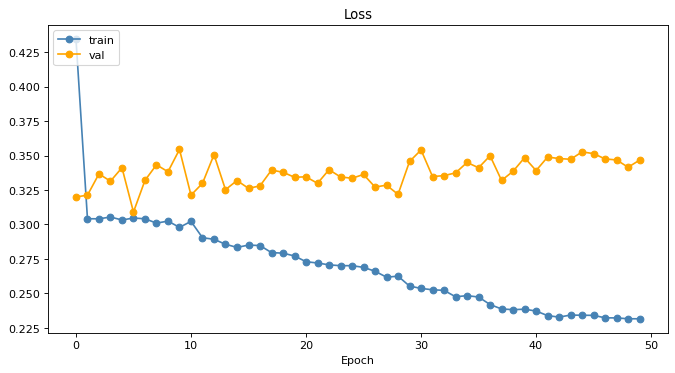

100%|██████████| 114/114 [00:25<00:00,  4.40it/s]


In [11]:
for model_name in model_names:
    backbone = resnet18(weights=None)
    backbone = load_pretrained_weights(backbone, model_name)
    backbone = _resnet_fpn_extractor(backbone, 0 if linear_eval == True else 5)
    if linear_eval:
        for name, param in backbone.body.named_parameters():
            assert param.requires_grad == False, f"{name} should not be trainable"
    out_channels = backbone.out_channels
    box_roi_pool = MultiScaleRoIAlign(
        featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2
    )
    resolution = box_roi_pool.output_size[0]
    box_head = TwoMLPHead(out_channels * resolution**2, representation_size)
    box_predictor = FastRCNNPredictor(
        representation_size,
        train_d.dataset.num_classes() + 1,
    )
    model = FasterRCNN(
        backbone,
        # num_classes=train_d.dataset.num_classes() + 1,
        box_roi_pool=box_roi_pool,
        box_head=box_head,
        box_predictor=box_predictor,
    )
    optimizer = torch.optim.AdamW(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=3e-4,
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=math.ceil(len(train_d.dataset) / batch_size)
        * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
        eta_min=1e-8,
    )
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        print(model_name)
        train_l = train_one_epoch(
            model,
            optimizer,
            train_d,
            device,
            epoch,
            max_norm=1,
            lr_scheduler=scheduler,
        )
        val_l, val_evaluator = evaluate(
            model=model,
            data_loader=val_d,
            device=device,
        )
        val_perf = val_evaluator.compute()
        train_losses.append(np.mean(train_l))
        val_losses.append(np.mean(val_l))
        clear_output()
        fig = plot_train(train_losses, val_losses, title="Loss")
    fig.savefig(
        os.path.join(
            "detection_results", f"{model_name}_{tune_mode}_detection_loss.png"
        )
    )
    _, test_evaluator, pred_result = evaluate(
        model=model,
        data_loader=test_d,
        device=device,
        get_preds=True,
    )
    test_perf = test_evaluator.compute()
    result_dict = {k: v.item() for k, v in test_perf.items()}
    result_dict["model_name"] = model_name
    result_dict["tune_mode"] = tune_mode
    pd.DataFrame([result_dict]).to_csv(
        os.path.join(
            "detection_results", f"{model_name}_{tune_mode}_detection_result.csv"
        )
    )
    pd.DataFrame(pred_result).to_csv(
        os.path.join(
            "detection_results", f"{model_name}_{tune_mode}_detection_preds.csv"
        )
    )
    save_model(f"{model_name}_{tune_mode}_detection", model, optimizer, scheduler)

In [12]:
model_name

'our_improved_v8'